# Interactive 1: Cerro Negro Isobar Plotting

Uses the pickled datasets produced in [this notebook](./Interaction1_dataset_creation.ipynb) to create an interactive plot.

## The dataset and plot

In this example, a plot is shown with H2O vs CO2 contents of multiple samples from one dataset. We here use the dataset of melt inclusions from Cerro Negro volcano in Nicaragua from Roggensack (2001). The user would be able to click on any data point to display the corresponding isobars for 500, 1000, 2000, 3000, and 4000 bars. The user could toggle the set of isobars for any datapoint by clicking that point on the figure. This is modeled after Figure 11 in VESIcal (Iacovino et al., 2021).

### The original Figure 11 from the manuscript is shown below for reference:

![Figure 11](Figure11.png)


## Import dependencies and notebook setup

In [1]:
!pip install ipywidgets
!pip install ipympl
!pip install pandas=='1.5.0'

import VESIcal as v
import pickle
import warnings
import pandas
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib widget

print(pandas.__version__)
if pandas.__version__ != '1.5.0':
    raise Exception('pandas 1.5.0 is required, update your environment and restart the kernel')

warnings.filterwarnings('ignore')

1.5.0


/Users/kiacovin/Dropbox/Research/_Published_Papers/2021_VESIcal/__TheCode/vesical-binder/.conda/lib/python3.9/site-packages/VESIcal/calculate_classes.py:7: UserWarning: 

  from VESIcal.models import magmasat


## Data loading and manipulation

In [2]:
#| caption: dip into the original dataset to get sample names then load the pre-prepared dataset
myfile =  v.BatchFile('cerro_negro.xlsx')
sample_names = [row.name for index, row in myfile.get_data().iterrows()]

with open('Interaction1_isobars.pickle', 'rb') as pkl:
    isobar_list = pickle.load(pkl)
    isobar_dict = {}
    for count, value in enumerate(isobar_list):
        isobar_dict[sample_names[count]] = value

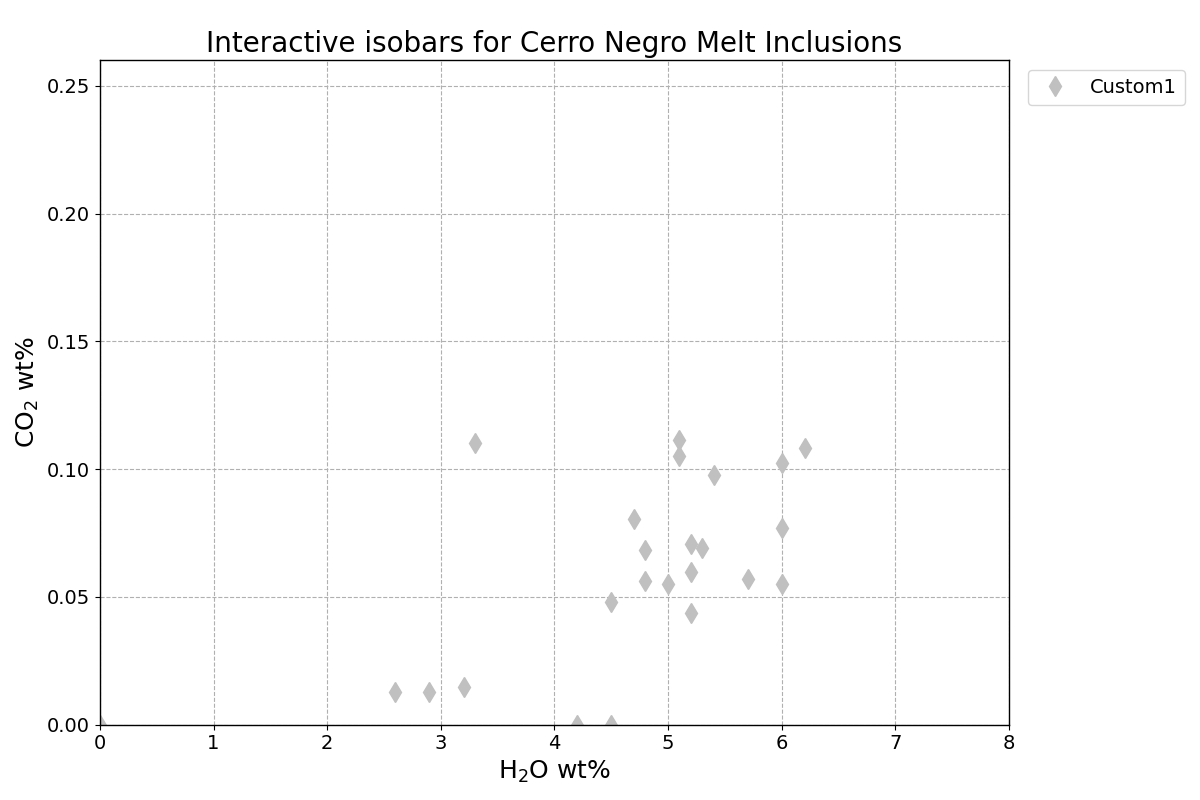

In [5]:
from collections import namedtuple

Selection = namedtuple("Selecton", ['ind', 'e', 'point', 'isobars', 'label', 'color'] )

class InteractiveIsobars:

    def __init__(self):
        # minimal state
        self.pick_radius = 8
        self.selected = {}
        self.plot_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

        # make the initial plot
        plt.ioff()
        self.fig, self.ax = v.plot(custom_H2O=[myfile.get_data()["H2O"]],
                custom_CO2=[myfile.get_data()["CO2"]],
                custom_colors=['silver'],
                custom_symbols=['d'])
        self.fig.canvas.header_visible = False
        self.fig.canvas.toolbar_visible = True
        self.fig.canvas.footer_visible = True
        self.fig.canvas.resizable = False
        self.fig.canvas.margin_top = '0px'
        self.fig.subplots_adjust()
        plt.title('Interactive isobars for Cerro Negro Melt Inclusions')
        plt.suptitle('')
        plt.grid(True, linestyle="--")

        def format_coord(x,y):
            return f"(H₂O wt%, CO₂ wt%): ({round(x, 2)}, {round(y,4)})"
        self.ax.format_coord = format_coord

        self.ax.set_xlim(0,8)
        self.ax.set_ylim(0,0.26)
        plt.tight_layout()
        plt.ion()
        v.show()

        # make points pickable
        lines = self.ax.get_lines()
        lines[0].set_picker(self.pick_radius)
        x_data, y_data = lines[0].get_data()

        # add text annotation
        texts = []
        for x,y,name in zip(x_data, y_data, sample_names):
            self.ax.text(x+0.03, y+0.001, name, fontsize=8.2, fontweight='bold', color='white', ha='left', va='bottom', zorder=10)
            texts.append(self.ax.text(x+0.03, y+0.001, name, fontsize=8, ha='left', va='bottom', zorder=11))
            

        def next_color():
            dict_colors = {obj.color for obj in self.selected.values()}
            filtered_colors = [color for color in self.plot_colors if color not in dict_colors]
            return  filtered_colors[0] if len(filtered_colors) > 0 else 'black'

        def rebuild_legend():
            ordered = [obj for obj in self.selected.values()]
            plt.legend(loc='upper right',
                       fontsize=8,
                       ncol=2,
                       fancybox=True,
                       handles=[*[obj.isobars[0] for obj in ordered], lines[0]],
                       labels=[*[obj.label for obj in ordered], 'Cerro Negro (Roggensack, 2001)'], markerscale=0.5)

        # pick event handler
        def on_pick(e):
            m = e.mouseevent
            if m.button == 'up' or m.button == 'down':
                    # ignore mouse scroll wheel
                    return

            ind = e.ind[0]
            if ind in self.selected:
                # toggle off
                self.selected[ind].point.remove()
                _=[ib.remove() for ib in self.selected[ind].isobars]
                del self.selected[ind]
                texts[ind].set_color('black')
                texts[ind].set_fontweight('normal')
                rebuild_legend()
                return

            # else plot a new isobar set
            color = next_color()
            x,y = x_data[ind], y_data[ind]
            # our point border is actually a new point
            point = self.ax.scatter(x,y, color=color, marker='d', s=230)
            # get smoothed isobar data, and plot direct with mpl
            isobar_data = v.vplot.smooth_isobars_and_isopleths(isobars=isobar_dict[sample_names[ind]])
            isobars = []
            for p, ib in isobar_data.groupby("Pressure"):
                isobars.append(self.ax.plot(ib['H2O_liq'], ib['CO2_liq'], color=color)[0])
            texts[ind].set_color(color)
            texts[ind].set_fontweight('bold')

            # sort out legend
            pressures = [str(ib) for ib in isobar_data["Pressure"].unique()]
            label = f"{sample_names[ind]} ({', '.join(pressures)} bars)"
            self.selected[ind] = Selection(ind, e, point, isobars, label, color)
            rebuild_legend()
                
        cid = self.fig.canvas.mpl_connect('pick_event', on_pick)
        rebuild_legend()

the_plot = InteractiveIsobars()